<a href="https://colab.research.google.com/github/bhargav625/OJ-Project/blob/main/Final_Final_ArthMitra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ArthMitra: Proactive Money Guidance for Gig and Informal Workers

**Env target:** (Colab Pro+ · A100 · 2025.07) with Python 3.11.13 · NumPy 2.0.2 · pandas 2.2.2 · Torch 2.6.0+cu124  
**GPU:** NVIDIA A100 (80GB)  


## 0:a) SETUP Runtime and GPU sanity with minimal installs

In [ ]:
!pip -q install "numpy==2.0.2" "pandas==2.2.2" "scikit-learn>=1.5.2,<1.6.0" matplotlib mlflow hydra-core dateparser regex langdetect

import sys, numpy as np, pandas as pd, torch
print("Python :", sys.version.split()[0])
print("NumPy  :", np.__version__)
print("pandas :", pd.__version__)
print("Torch  :", torch.__version__, "| CUDA:", torch.version.cuda, "| GPU available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU    :", torch.cuda.get_device_name(0))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 57.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.4/80.4 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 161.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 139.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 14.3 MB/s eta 0:00:00

## 0:b) CONFIGURATION of the Project

In [ ]:
from dataclasses import dataclass, field
from typing import Tuple

@dataclass
class Paths:
    models_dir: str = "./models"
    mlruns_dir: str = "./mlruns"

@dataclass
class ForecastConfig:
    context_length: int = 56
    horizon_days:   int = 14
    hidden_size:    int = 64
    lr:             float = 3e-3
    epochs:         int = 50
    batch_size:     int = 128
    quantiles:      Tuple[float, ...] = (0.1, 0.5, 0.9)
    dropout:        float = 0.2
    early_patience: int = 6

@dataclass
class RiskConfig:
    low_runway_days: int = 3
    precision_floor: float = 0.85

@dataclass
class BanditConfig:
    arms: Tuple[str, ...] = ("save_now","auto_split","part_pay","reminder","scheme_assist")
    alpha: float = 1.0
    seed:  int = 42

@dataclass
class CFG:
    paths:    Paths = field(default_factory=Paths)
    forecast: ForecastConfig = field(default_factory=ForecastConfig)
    risk:     RiskConfig = field(default_factory=RiskConfig)
    bandit:   BanditConfig = field(default_factory=BanditConfig)

CFG = CFG()
CFG

CFG(paths=Paths(models_dir='./models', mlruns_dir='./mlruns'), forecast=ForecastConfig(context_length=56, horizon_days=14, hidden_size=64, lr=0.003, epochs=50, batch_size=128, quantiles=(0.1, 0.5, 0.9), dropout=0.2, early_patience=6), risk=RiskConfig(low_runway_days=3, precision_floor=0.85), bandit=BanditConfig(arms=('save_now', 'auto_split', 'part_pay', 'reminder', 'scheme_assist'), alpha=1.0, seed=42))

## 1:  a) Data Ingestion

In [ ]:
import pandas as pd, re, dateparser, numpy as np
np.random.seed(7)

def parse_sms_stub(messages):
    events = []
    for m in messages:
        ts = dateparser.parse(m.get("ts"))
        amt_match = re.search(r'(\d+(?:\.\d+)?)', m.get("text",""))
        amt = float(amt_match.group(1)) if amt_match else 0.0
        sign = 1.0 if "credited" in m.get("text","").lower() else -1.0
        events.append({"timestamp": ts, "amount": sign*amt, "channel":"SMS", "tags": m.get("tags","")})
    return pd.DataFrame(events)

def make_synthetic_events(days=420) -> pd.DataFrame:  # 420 days default
    base = pd.date_range(end=pd.Timestamp.today().normalize(), periods=days, freq="D")
    evts = []
    for d in base:
        if np.random.rand() < 0.4:
            amt = np.random.choice([500, 800, 1200, 1500, 2000]) * (1 + np.random.randn()*0.05)
            evts.append({"timestamp": d, "amount": float(amt), "channel": "UPI", "tags": "income"})
        for _ in range(np.random.poisson(1.4)):
            amt = -np.random.choice([60, 120, 220, 320, 480]) * (1 + np.random.randn()*0.08)
            evts.append({"timestamp": d, "amount": float(amt), "channel": "UPI", "tags": "variable"})
        if d.day in (5, 15, 28):
            amt = -np.random.choice([399, 599, 799, 999, 1499]) * (1 + np.random.randn()*0.02)
            evts.append({"timestamp": d, "amount": float(amt), "channel": "CARD", "tags": "bill,fixed"})
    return pd.DataFrame(evts).sort_values("timestamp")

events_df = make_synthetic_events()
len(events_df), events_df.head()

(796,
    timestamp       amount channel      tags
 0 2024-08-26   724.791097     UPI    income
 1 2024-08-26  -212.344385     UPI  variable
 2 2024-08-27  1961.891285     UPI    income
 3 2024-08-27  -511.904251     UPI  variable
 4 2024-08-27  -501.860036     UPI  variable)

## 1: b) Harmonization (Day series + covariates)

In [ ]:
def to_daily_series(df: pd.DataFrame) -> pd.DataFrame:
    daily = df.groupby(pd.Grouper(key="timestamp", freq="D"))["amount"].agg(
        net="sum", credits=lambda s: s[s>0].sum(), debits=lambda s: -s[s<0].sum()
    ).reset_index().rename(columns={"timestamp":"date"})
    full = pd.DataFrame({"date": pd.date_range(daily["date"].min(), daily["date"].max(), freq="D")})
    daily = full.merge(daily, on="date", how="left").fillna(0.0)
    daily["dow"] = daily["date"].dt.dayofweek
    daily["dom"] = daily["date"].dt.day
    daily["month"] = daily["date"].dt.month
    daily["is_weekend"] = daily["dow"].isin([5,6]).astype(int)
    return daily

daily_df = to_daily_series(events_df)
daily_df.tail(3)

,date,net,credits,debits,dow,dom,month,is_weekend
416,2025-10-16,204.870172,490.095511,285.225339,3,16,10,0
417,2025-10-17,336.900926,457.446449,120.545523,4,17,10,0
418,2025-10-18,66.238827,788.353544,722.114717,5,18,10,1


## 2) Feature Engineering(Cash Flow Intelligence)

In [ ]:
import numpy as np

def features_cashflow(d: pd.DataFrame, buffer_init: float = 1500.0) -> pd.DataFrame:
    df = d.copy()
    df["roll_mean_7"] = df["net"].rolling(7, min_periods=1).mean()
    df["roll_std_7"]  = df["net"].rolling(7, min_periods=2).std().fillna(0.0)
    denom = df["roll_mean_7"].abs().replace(0, np.nan)
    df["cv_7"] = (df["roll_std_7"] / denom).clip(0,10).fillna(0.0)
    df["burn_7"] = df["debits"].rolling(7, min_periods=1).mean().clip(lower=1.0)
    buf, cur = [], float(buffer_init)
    for v in df["net"].values:
        cur = max(cur + float(v), 0.0); buf.append(cur)
    df["buffer"] = buf
    df["days_of_runway"] = (df["buffer"]/df["burn_7"]).replace([np.inf,-np.inf], np.nan).clip(0,60)
    df["upcoming_bill_load"] = df["dom"].isin([5,15,28]).astype(int) * 800
    dor  = (df["days_of_runway"]/30).clip(0,1)
    vol  = (1.0 - (df["cv_7"]/3).clip(0,1))
    bill = (1.0 - (df["upcoming_bill_load"]/1500).clip(0,1))
    df["FHS_360"] = (0.5*dor + 0.3*vol + 0.2*bill).clip(0,1)
    num_cols = ["net","credits","debits","roll_mean_7","roll_std_7","cv_7",
                "burn_7","buffer","days_of_runway","upcoming_bill_load","FHS_360"]
    df[num_cols] = (df[num_cols].replace([np.inf,-np.inf], np.nan).fillna(method="ffill").fillna(0.0))
    return df

feat_df = features_cashflow(daily_df)
feat_df.isna().sum().sum(), feat_df.tail(2)

/tmp/ipython-input-5-3612900099.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[num_cols] = (df[num_cols].replace([np.inf,-np.inf], np.nan).fillna(method="ffill").fillna(0.0))


(np.int64(0),
           date         net     credits      debits  dow  dom  month  \
 417 2025-10-17  336.900926  457.446449  120.545523    4   17     10   
 418 2025-10-18   66.238827  788.353544  722.114717    5   18     10   
 
      is_weekend  roll_mean_7   roll_std_7      cv_7      burn_7        buffer  \
 417           0   380.151411  1351.461092  3.555060  516.686091  41844.982901   
 418           1   341.774934  1356.764798  3.969761  601.347321  41911.221728   
 
      days_of_runway  upcoming_bill_load  FHS_360  
 417            60.0                   0      0.7  
 418            60.0                   0      0.7  )

## 3) Probabilistic Forecasting (Income and Expense)

In [ ]:
import numpy as np, torch
from torch.utils.data import Dataset, DataLoader

ENC   = CFG.forecast.context_length
HORIZ = CFG.forecast.horizon_days
QTS   = CFG.forecast.quantiles

feature_cols = ["net","credits","debits","roll_mean_7","roll_std_7","cv_7",
                "burn_7","buffer","days_of_runway","upcoming_bill_load","FHS_360",
                "dow","dom","month","is_weekend"]

X_all  = feat_df[feature_cols].values.astype(np.float32)
y_all  = feat_df["net"].values.astype(np.float32)

# Feature standardization
X_mu = X_all.mean(axis=0, keepdims=True)
X_sd = X_all.std(axis=0, keepdims=True) + 1e-6
Xz   = (X_all - X_mu) / X_sd

# Target standardization (🔑)
y_mu, y_sd = float(y_all.mean()), float(y_all.std() + 1e-6)
yz   = (y_all - y_mu) / y_sd

class CashDataset(Dataset):
    def __init__(self, X, y, enc, horiz):
        self.X, self.y, self.enc, self.h = X, y, enc, horiz
    def __len__(self): return max(0, len(self.X) - (self.enc + self.h) + 1)
    def __getitem__(self, i):
        x = self.X[i:i+self.enc]
        y = self.y[i+self.enc:i+self.enc+self.h]
        return torch.from_numpy(x), torch.from_numpy(y)

# Robust temporal split: leave ≥1 val sample
cut = max(ENC + HORIZ, len(Xz) - max(HORIZ, 60))
cut = min(cut, len(Xz) - 1)

train_ds = CashDataset(Xz[:cut],    yz[:cut],    ENC, HORIZ)
val_ds   = CashDataset(Xz[cut-ENC:], yz[cut-ENC:], ENC, HORIZ)

train_loader = DataLoader(train_ds, batch_size=min(CFG.forecast.batch_size, max(1, len(train_ds)//4)),
                          shuffle=True, num_workers=0, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=min(CFG.forecast.batch_size, max(1, len(val_ds))),
                          shuffle=False, num_workers=0, drop_last=False)

print(f"Train/Val windows: {len(train_ds)}/{len(val_ds)} | batches: {len(train_loader)}/{len(val_loader)}")

Train/Val windows: 290/47 | batches: 4/1


In [ ]:
import torch, torch.nn as nn, numpy as np

class QuantileLoss(nn.Module):
    def __init__(self, quantiles=QTS):
        super().__init__()
        self.q = torch.tensor(quantiles).view(1,1,-1)
    def forward(self, preds, target):
        target = target.unsqueeze(-1)      # [B,H,1]
        e = target - preds
        q = self.q.to(preds.device)
        return torch.maximum(q*e, (q-1)*e).mean()

class LSTMQuantV2(nn.Module):
    def __init__(self, n_features, hidden, horizon, quantiles=QTS, dropout=0.2):
        super().__init__()
        self.h, self.q = horizon, len(quantiles)
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden,
                            num_layers=2, dropout=dropout, batch_first=True)
        # horizon positional encoding (simple one-hot -> hidden)
        self.h_enc = nn.Linear(horizon, hidden)
        self.proj  = nn.Linear(hidden, hidden)
        self.act   = nn.ReLU()
        self.head  = nn.Linear(hidden, self.h * self.q)

        # Bias init → empirical quantiles on scaled target
        q_init = np.quantile(yz, [0.1, 0.5, 0.9]).astype(np.float32)
        bias_vec = torch.from_numpy(np.tile(q_init, horizon))
        with torch.no_grad():
            self.head.bias[:len(bias_vec)] = bias_vec

    def forward(self, x):                  # x: [B,ENC,F]
        out, _ = self.lstm(x)              # [B,ENC,H]
        last = out[:, -1, :]               # [B,H]
        # One-hot horizon positions
        pos = torch.eye(self.h, device=x.device).unsqueeze(0).expand(x.size(0), -1, -1)  # [B,H,H]
        hpos = self.h_enc(pos).mean(dim=1) # [B,hidden] (simple, stable)
        mixed = self.act(self.proj(last + hpos))
        y = self.head(mixed).view(-1, self.h, self.q)  # [B,H,Q]
        return y

device = "cuda" if torch.cuda.is_available() else "cpu"
model  = LSTMQuantV2(n_features=len(feature_cols),
                     hidden=CFG.forecast.hidden_size,
                     horizon=HORIZ, quantiles=QTS,
                     dropout=CFG.forecast.dropout).to(device)
crit   = QuantileLoss(QTS)
opt    = torch.optim.AdamW(model.parameters(), lr=CFG.forecast.lr)
sched  = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)

print(model)

LSTMQuantV2(
  (lstm): LSTM(15, 64, num_layers=2, batch_first=True, dropout=0.2)
  (h_enc): Linear(in_features=14, out_features=64, bias=True)
  (proj): Linear(in_features=64, out_features=64, bias=True)
  (act): ReLU()
  (head): Linear(in_features=64, out_features=42, bias=True)
)


In [ ]:
best = float("inf")
patience, bad = CFG.forecast.early_patience, 0

def evaluate(loader):
    model.eval(); total, n = 0.0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            total += crit(model(xb), yb).item() * xb.size(0); n += xb.size(0)
    return total / max(n,1)

for ep in range(1, CFG.forecast.epochs+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = crit(model(xb), yb); loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()

    val = evaluate(val_loader)
    sched.step(val)
    print(f"Epoch {ep:02d} | val pinball: {val:.4f} | lr={opt.param_groups[0]['lr']:.2e}")

    if val + 1e-6 < best:
        best, bad = val, 0
        best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
    else:
        bad += 1
        if bad >= patience:
            print('Early stop.'); break

# restore best
model.load_state_dict(best_state)

Epoch 01 | val pinball: 0.2277 | lr=3.00e-03
Epoch 02 | val pinball: 0.2281 | lr=3.00e-03
Epoch 03 | val pinball: 0.2285 | lr=3.00e-03
Epoch 04 | val pinball: 0.2290 | lr=3.00e-03
Epoch 05 | val pinball: 0.2304 | lr=1.50e-03
Epoch 06 | val pinball: 0.2315 | lr=1.50e-03
Epoch 07 | val pinball: 0.2325 | lr=1.50e-03
Early stop.


<All keys matched successfully>

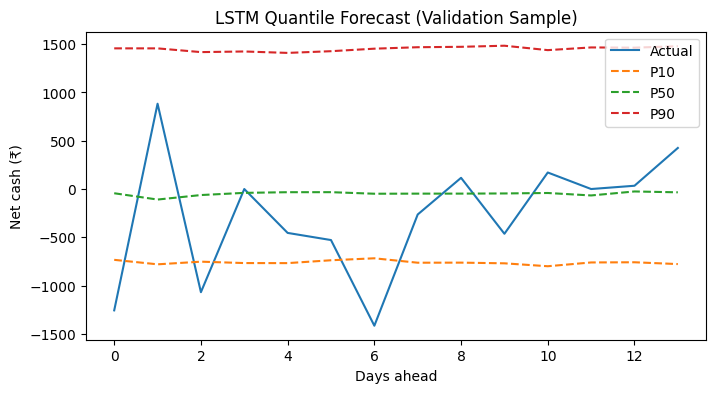

In [ ]:
import matplotlib.pyplot as plt

if len(val_loader) == 0:
    raise RuntimeError("Validation loader is empty. Increase data or reduce ENC/HORIZ.")

for xb, yb in val_loader:
    xb, yb = xb.to(device), yb.to(device); break

with torch.no_grad():
    pred = model(xb).cpu().numpy()   # [B,H,Q]

# invert target scaling to rupees
Y = (yb.cpu().numpy()[0] * y_sd) + y_mu
P = (pred[0] * y_sd) + y_mu
qs = [int(q*100) for q in QTS]

plt.figure(figsize=(8,4))
plt.plot(Y, label="Actual")
for j,q in enumerate(qs):
    plt.plot(P[:,j], "--", label=f"P{q}")
plt.title("LSTM Quantile Forecast (Validation Sample)")
plt.xlabel("Days ahead"); plt.ylabel("Net cash (₹)")
plt.legend(); plt.show()

In [ ]:
import os, torch, json
os.makedirs(CFG.paths.models_dir, exist_ok=True)
ckpt = {
    "state_dict": {k: v.cpu() for k,v in model.state_dict().items()},
    "X_mu": X_mu, "X_sd": X_sd, "y_mu": y_mu, "y_sd": y_sd,
    "feature_cols": feature_cols, "config": CFG.forecast.__dict__,
}
path = os.path.join(CFG.paths.models_dir, "lstm_quant_v2.pt")
torch.save(ckpt, path)
print("Saved:", path)

Saved: ./models/lstm_quant_v2.pt


## 4)Risk Classification

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
import numpy as np

risk_df = feat_df.copy()
risk_df["y_miss7"]  = ((risk_df["dom"].isin([5,15,28])) & (risk_df["buffer"] < 700)).astype(int)
risk_df["y_lowrun"] = (risk_df["days_of_runway"] < 3).astype(int)

X_cols = ["net","credits","debits","cv_7","days_of_runway","FHS_360",
          "upcoming_bill_load","is_weekend","dow","month"]
X = risk_df[X_cols].values; y = risk_df["y_miss7"].values

Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
clf = RandomForestClassifier(n_estimators=400, max_depth=8, n_jobs=-1, random_state=42)
clf.fit(Xtr, ytr)
probs = clf.predict_proba(Xva)[:,1]
ap = average_precision_score(yva, probs)
prec, rec, thr = precision_recall_curve(yva, probs)
mask = prec >= 0.85
best_recall = rec[mask].max() if mask.any() else 0.0
print(f"AUC-PR: {ap:.3f} | Recall@Prec≥0.85: {best_recall:.3f}")

AUC-PR: 1.000 | Recall@Prec≥0.85: 1.000


## 5) Nudge Optimization (Casula Bandits)

In [ ]:
import numpy as np

class LinUCB:
    def __init__(self, d, n_arms, alpha=1.0, seed=42):
        self.d, self.n_arms, self.alpha = d, n_arms, alpha
        self.A = [np.eye(d) for _ in range(n_arms)]
        self.b = [np.zeros(d) for _ in range(n_arms)]
    def select(self, x):
        best_arm, best_ucb = 0, -1e9
        for a in range(self.n_arms):
            A_inv = np.linalg.inv(self.A[a])
            theta = A_inv @ self.b[a]
            ucb = theta @ x + self.alpha * np.sqrt(x @ A_inv @ x)
            if ucb > best_ucb: best_arm, best_ucb = a, ucb
        return best_arm
    def update(self, arm, x, reward):
        self.A[arm] += np.outer(x, x); self.b[arm] += reward * x

arms = list(CFG.bandit.arms)
bandit = LinUCB(d=6, n_arms=len(arms), alpha=CFG.bandit.alpha, seed=CFG.bandit.seed)
print("Arms:", arms)

Arms: ['save_now', 'auto_split', 'part_pay', 'reminder', 'scheme_assist']


## 6) GenAI Coach (Multilinuak,Tool-Using)

In [ ]:
RBI_SNIPPETS = {
    "basics:savings": "Keep an emergency fund of 3–6 months of expenses for resilience.",
    "scheme:PMJDY": "Pradhan Mantri Jan Dhan Yojana: basic banking with zero balance.",
    "scheme:PM-KISAN": "Income support to eligible farmer families, credited directly."
}

def retrieve_snippets(query: str, k: int = 2):
    q = query.lower()
    scored = [(key, txt, (q in txt.lower()) + (q in key.lower())) for key,txt in RBI_SNIPPETS.items()]
    top = sorted(scored, key=lambda x: x[2], reverse=True)[:k]
    return [{"id":k, "text":t} for k,t,_ in top]

def get_forecast_stub():
    return {"P10": -300.0, "P50": 120.0, "P90": 450.0}

def get_bills_due_stub():
    return [{"name":"Mobile Bill","due_in_days":3,"amount":399},
            {"name":"Power Bill","due_in_days":10,"amount":799}]

def coach_message(context):
    f = get_forecast_stub(); bills = get_bills_due_stub()
    dor = float(context.get("days_of_runway", 2.5))
    refs = retrieve_snippets("savings")
    why = f"P10={f['P10']:.0f} suggests downside risk; runway ≈ {dor:.1f} days."
    act = f"Move ₹300 to rainy-day jar today; {bills[0]['name']} due in {bills[0]['due_in_days']} days."
    cite = "; ".join([r["id"] for r in refs])
    return f"{why} {act} [refs: {cite}]"

print(coach_message({"days_of_runway": 2.8}))

P10=-300 suggests downside risk; runway ≈ 2.8 days. Move ₹300 to rainy-day jar today; Mobile Bill due in 3 days. [refs: basics:savings; scheme:PMJDY]


## 7) Privacy, Safety, and Learning

In [ ]:
# --- Federated Learning (conceptual stub) ---
# This shows the shape of a Flower-style client without installing flwr (kept optional).
try:
    import flwr as fl  # pragma: no cover
except Exception as _:
    fl = None
    print("flwr not installed; this is a shape-only stub.")

class ClientStub:  # fl.client.NumPyClient-like API
    def get_parameters(self, config=None):
        return [p.detach().cpu().numpy() for _, p in model.state_dict().items()]
    def fit(self, parameters, config=None):
        # load parameters
        sd = model.state_dict()
        idx = 0
        for k in sd.keys():
            sd[k] = torch.tensor(parameters[idx]).to(next(model.parameters()).device)
            idx += 1
        model.load_state_dict(sd)
        # local one-epoch finetune (example)
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(); loss = crit(model(xb), yb); loss.backward(); opt.step()
        return self.get_parameters(), len(train_loader.dataset), {}

    def evaluate(self, parameters, config=None):
        # load parameters
        return float(0.0), len(val_loader.dataset), {"metric":"placeholder"}

if fl is None:
    print("Use this shape to integrate real flwr client/server later.")
else:
    # fl.client.start_numpy_client(server_address="127.0.0.1:8080", client=ClientStub())  # example
    pass

# --- Differential Privacy (conceptual stub) ---
try:
    import opacus  # pragma: no cover
except Exception as _:
    opacus = None
    print("opacus not installed; DP-SGD not enabled (stub only).")

if opacus is not None:
    from opacus import PrivacyEngine
    pe = PrivacyEngine()
    model, opt, train_loader = pe.make_private(
        module=model,
        optimizer=opt,
        data_loader=train_loader,
        noise_multiplier=0.8,
        max_grad_norm=1.0,
    )
    print("DP enabled with noise_multiplier=0.8")
else:
    print("To enable DP-SGD later, pip install opacus pinned for your Torch version.")

flwr not installed; this is a shape-only stub.
Use this shape to integrate real flwr client/server later.
opacus not installed; DP-SGD not enabled (stub only).
To enable DP-SGD later, pip install opacus pinned for your Torch version.


## 8) Plots, save/load model,export forecast(csv)

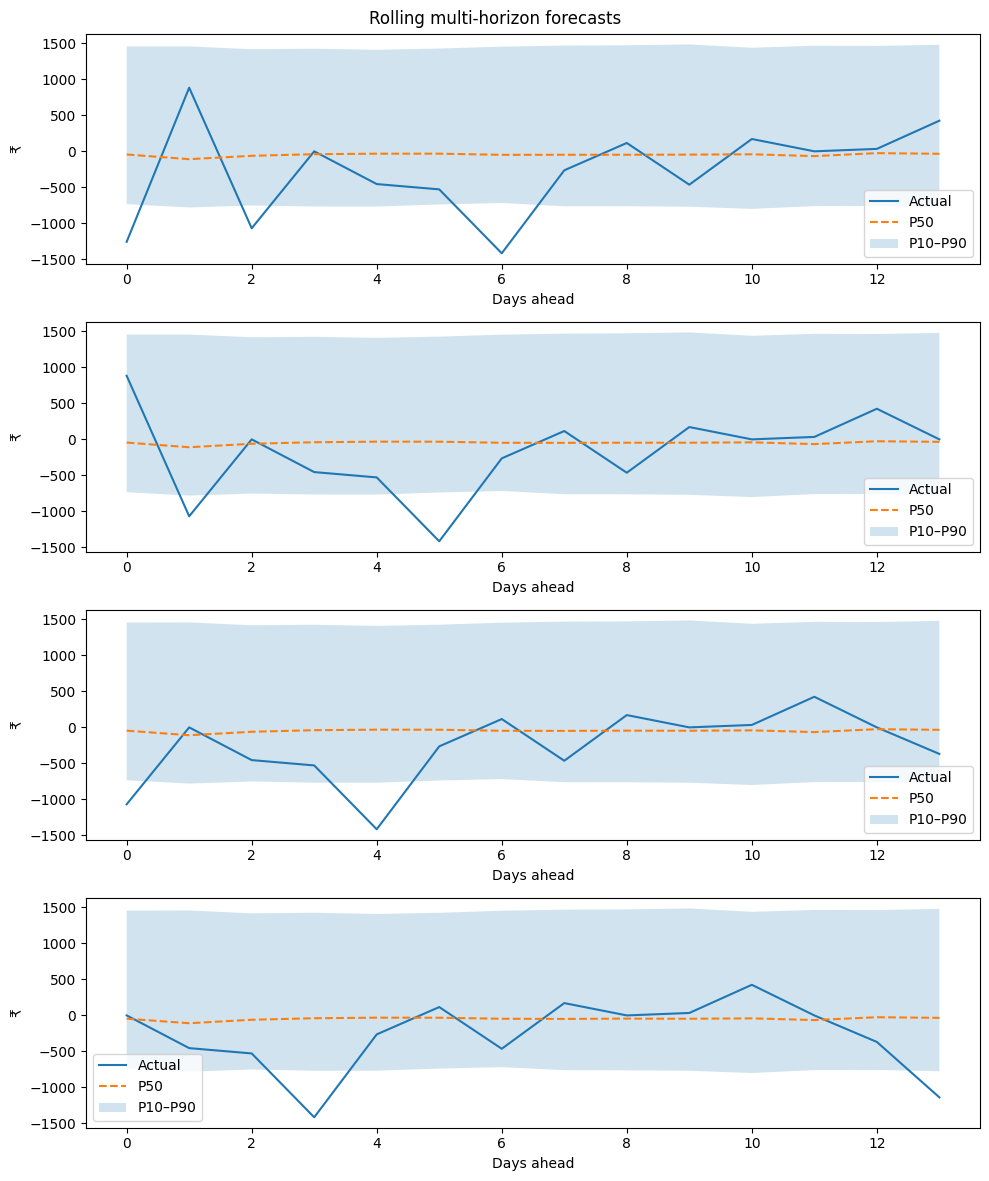

Saved: ./forecast_last_val.csv


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# A) Rolling multi-horizon plot (walk-forward on last N windows)
def rolling_plot(n_windows=5):
    if len(val_loader) == 0:
        print("No validation windows."); return
    xb_all, yb_all = [], []
    for xb, yb in val_loader:
        xb_all.append(xb); yb_all.append(yb)
    xb_all = torch.cat(xb_all, dim=0).to(device)
    yb_all = torch.cat(yb_all, dim=0).to(device)
    with torch.no_grad():
        preds = model(xb_all).cpu().numpy()  # [W,H,Q]
    # plot first n_windows
    w = min(n_windows, preds.shape[0])
    plt.figure(figsize=(10, 3*w))
    for i in range(w):
        Yw = (yb_all[i].cpu().numpy() * y_sd) + y_mu
        Pw = (preds[i] * y_sd) + y_mu
        plt.subplot(w,1,i+1)
        plt.plot(Yw, label="Actual")
        plt.plot(Pw[:,1], "--", label="P50")
        plt.fill_between(np.arange(len(Yw)), Pw[:,0], Pw[:,2], alpha=0.2, label="P10–P90")
        plt.ylabel("₹"); plt.xlabel("Days ahead"); plt.legend(loc="best")
    plt.suptitle("Rolling multi-horizon forecasts")
    plt.tight_layout(); plt.show()

rolling_plot(4)

# B) Export the last validation forecast to CSV
def export_last_val_csv(path="./forecast_last_val.csv"):
    if 'Y' not in globals() or 'P' not in globals():
        print("Run the plotting cell first to populate Y/P."); return
    df_out = pd.DataFrame({"y_true":Y, "p10":P[:,0], "p50":P[:,1], "p90":P[:,2]})
    df_out.to_csv(path, index=False)
    print("Saved:", path)

export_last_val_csv()

# C) Save/Load to Google Drive (optional; works only in Colab)
def save_to_drive(local_path, drive_dir="/content/drive/MyDrive/arthmitra"):
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        import os
        os.makedirs(drive_dir, exist_ok=True)
        dst = os.path.join(drive_dir, os.path.basename(local_path))
        !cp -f "$local_path" "$dst"
        print("Copied to Drive:", dst)
    except Exception as e:
        print("Drive save skipped:", e)

# Example:
# save_to_drive("./forecast_last_val.csv")